# Abalone Rings Classification using CNN

## Baseline

To find out the lower bound of abalone rings classification capability using CNNs, let's conduct a baseline experiment which has no modifications.

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [47]:
data = pd.read_csv('data/abalone.csv')
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop(['Rings', 'id'], axis=1).values
y = data['Rings'].values - 1

In [48]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled).unsqueeze(1)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
y_test_tensor = torch.LongTensor(y_test)

In [49]:
class AbaloneDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [50]:
train_dataset = AbaloneDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = AbaloneDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = AbaloneDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [51]:
class AbaloneClassificationConv1D(nn.Module):
    def __init__(self, num_classes):
        super(AbaloneClassificationConv1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(np.unique(y)) + 1
net = AbaloneClassificationConv1D(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [53]:
num_epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()

    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Train Accuracy: 0.2241, Validation Accuracy: 0.2513
Epoch [20/100], Train Accuracy: 0.2626, Validation Accuracy: 0.2598
Epoch [30/100], Train Accuracy: 0.2823, Validation Accuracy: 0.2650
Epoch [40/100], Train Accuracy: 0.2960, Validation Accuracy: 0.2598
Epoch [50/100], Train Accuracy: 0.2784, Validation Accuracy: 0.2427
Epoch [60/100], Train Accuracy: 0.2917, Validation Accuracy: 0.2632
Epoch [70/100], Train Accuracy: 0.3007, Validation Accuracy: 0.2769
Epoch [80/100], Train Accuracy: 0.2934, Validation Accuracy: 0.2564
Epoch [90/100], Train Accuracy: 0.2956, Validation Accuracy: 0.2718
Epoch [100/100], Train Accuracy: 0.3148, Validation Accuracy: 0.2786


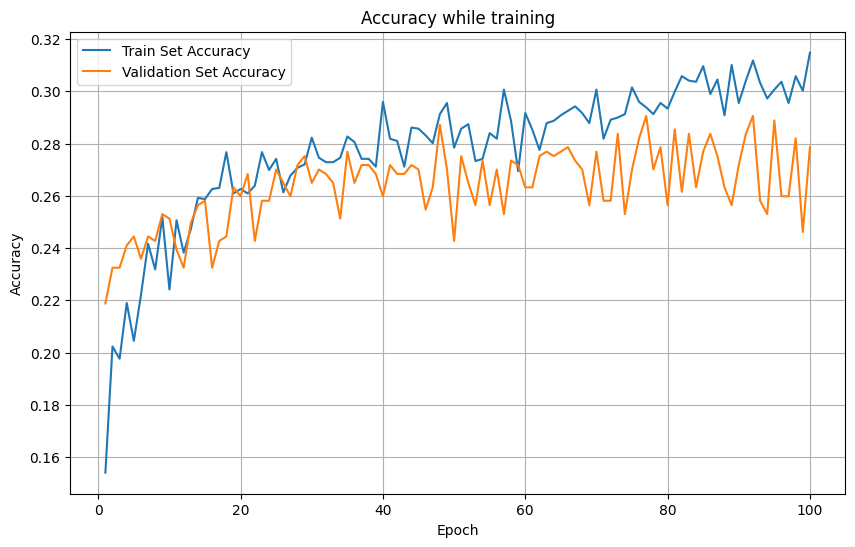

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [55]:
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, predicted))

Test Accuracy: 0.2791
Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           3       0.33      0.84      0.47        19
           4       0.43      0.07      0.12        45
           5       0.33      0.34      0.34        77
           6       0.40      0.41      0.41       129
           7       0.38      0.29      0.33       164
           8       0.29      0.46      0.36       212
           9       0.24      0.30      0.26       191
          10       0.23      0.22      0.22       137
          11       0.00      0.00      0.00        84
          12       0.09      0.21      0.13        53
          13       0.67      0.06      0.11        34
          14       0.17      0.10      0.12        31
          15       0.29      0.19      0.23        21
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        15
          18       0.00      0.00   

/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

The accuracy of the baseline experiment in the test dataset is **0.2791**.

## Variant 1: Change the order of the columns in the dataset

As the model consists of Conv1D layer, the spatial relation matters. Changing the order of the columns might improve training.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [7]:
data = pd.read_csv('data/abalone.csv')

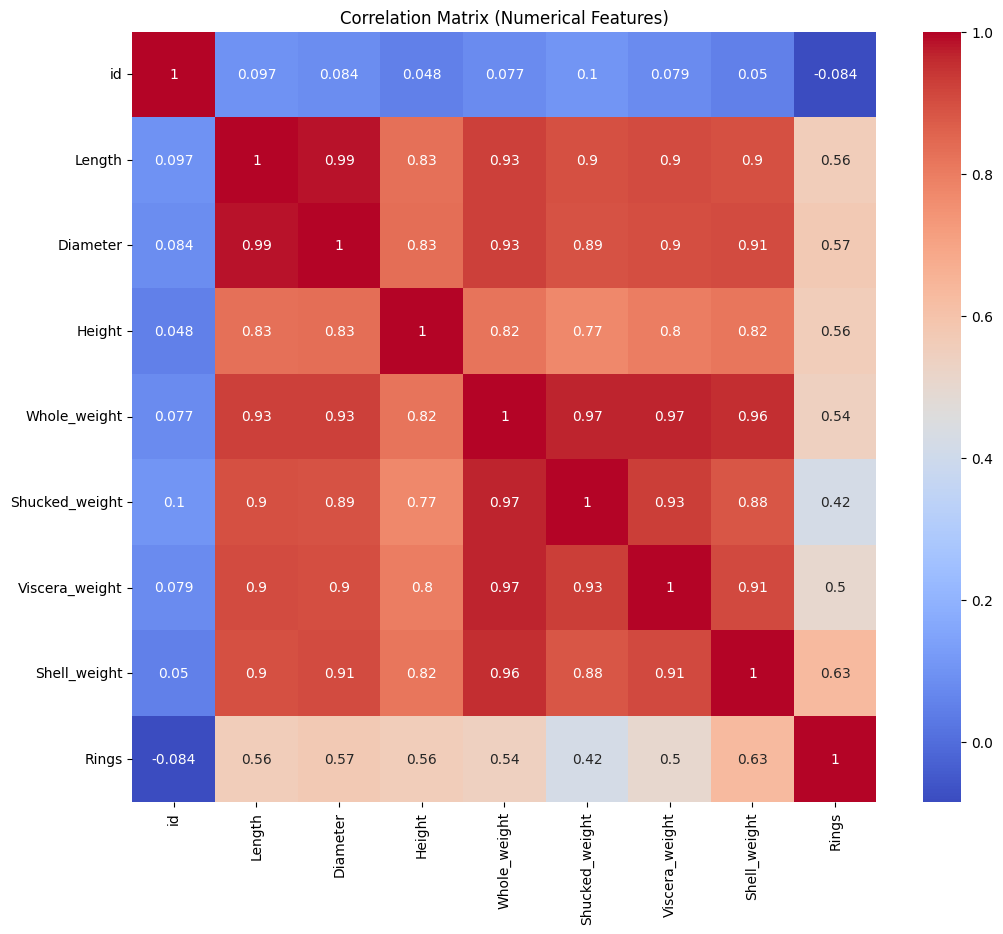

In [8]:
numerical_columns = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
sns.heatmap(data[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

This is the correlation matrix of the dataset. "Rings" and "Shell_weight" is most correlated and "Shell_weight" shows correlation with "Whole_weight", "Viscera_weight", and "Diameter".

Based on this knowledge, let's re-order the columns by setting "Shell_weight" on the middle and locate "Whole_weight", "Viscera_weight", and "Diameter" closely.

In [9]:
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

reordered_columns = ['Sex', 'Height', 'Length', 'Diameter', 'Whole_weight', 'Shell_weight', 'Viscera_weight', 'Shucked_weight']

data_reordered = data[reordered_columns + ['Rings', 'id']]

print(data_reordered.head())

X = data_reordered.drop(['Rings', 'id'], axis=1).values
y = data_reordered['Rings'].values - 1

   Sex  Height  Length  Diameter  Whole_weight  Shell_weight  Viscera_weight  \
0    0   0.095   0.455     0.365        0.5140         0.150          0.1010   
1    0   0.090   0.350     0.265        0.2255         0.070          0.0485   
2    1   0.135   0.530     0.420        0.6770         0.210          0.1415   
3    0   0.125   0.440     0.365        0.5160         0.155          0.1140   
4    2   0.080   0.330     0.255        0.2050         0.055          0.0395   

   Shucked_weight  Rings  id  
0          0.2245     15   0  
1          0.0995      7   1  
2          0.2565      9   2  
3          0.2155     10   3  
4          0.0895      7   4  


In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled).unsqueeze(1)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
y_test_tensor = torch.LongTensor(y_test)

In [12]:
class AbaloneDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
train_dataset = AbaloneDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = AbaloneDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = AbaloneDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
class AbaloneClassificationConv1D(nn.Module):
    def __init__(self, num_classes):
        super(AbaloneClassificationConv1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(np.unique(y)) + 1
net = AbaloneClassificationConv1D(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [16]:
num_epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()

    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Train Accuracy: 0.2575, Validation Accuracy: 0.2444
Epoch [20/100], Train Accuracy: 0.2660, Validation Accuracy: 0.2581
Epoch [30/100], Train Accuracy: 0.2754, Validation Accuracy: 0.2718
Epoch [40/100], Train Accuracy: 0.2737, Validation Accuracy: 0.2718
Epoch [50/100], Train Accuracy: 0.2707, Validation Accuracy: 0.2701
Epoch [60/100], Train Accuracy: 0.2814, Validation Accuracy: 0.2821
Epoch [70/100], Train Accuracy: 0.2737, Validation Accuracy: 0.2701
Epoch [80/100], Train Accuracy: 0.2968, Validation Accuracy: 0.2735
Epoch [90/100], Train Accuracy: 0.2998, Validation Accuracy: 0.2940
Epoch [100/100], Train Accuracy: 0.2994, Validation Accuracy: 0.2684


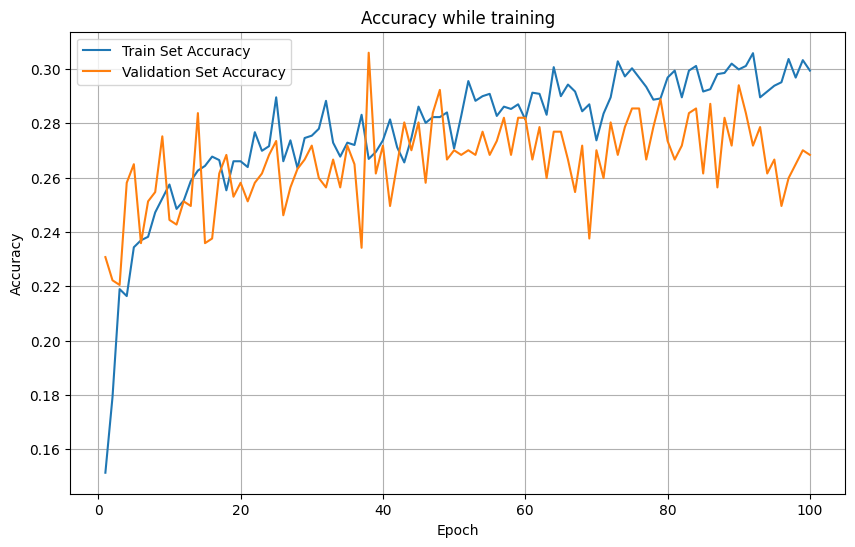

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [18]:
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, predicted))

Test Accuracy: 0.2855
Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           3       0.36      0.63      0.46        19
           4       1.00      0.02      0.04        45
           5       0.33      0.48      0.39        77
           6       0.40      0.43      0.42       129
           7       0.39      0.37      0.38       164
           8       0.32      0.38      0.35       212
           9       0.23      0.42      0.30       191
          10       0.22      0.12      0.15       137
          11       0.00      0.00      0.00        84
          12       0.09      0.13      0.10        53
          13       0.17      0.06      0.09        34
          14       0.09      0.06      0.08        31
          15       0.25      0.10      0.14        21
          16       0.50      0.07      0.12        14
          17       0.00      0.00      0.00        15
          18       0.00      0.00   

/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Changing the order of the columns improves, but not significantly.

## Variant 2: Feature Engineering

For better representation, let's conduct feature engineering. As the abalone dataset is a well-knowned to others, many feature engineering techniques were developed.

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [47]:
data = pd.read_csv('data/abalone.csv')
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

# Ratio Features
data['Length_to_Diameter'] = data['Length'] / data['Diameter']
data['Shucked_to_Whole'] = data['Shucked_weight'] / data['Whole_weight']
data['Shell_to_Whole'] = data['Shell_weight'] / data['Whole_weight']

# Polynomial Features
data['Length_squared'] = data['Length'] ** 2
data['Diameter_squared'] = data['Diameter'] ** 2

# Logarithmic transformation for weight features
weight_features = ['Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
for feature in weight_features:
    data[f'Log_{feature}'] = np.log1p(data[feature])

print(data.head())

X = data.drop(['Rings', 'id'], axis=1).values
y = data['Rings'].values - 1

   id  Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
0   0    0   0.455     0.365   0.095        0.5140          0.2245   
1   1    0   0.350     0.265   0.090        0.2255          0.0995   
2   2    1   0.530     0.420   0.135        0.6770          0.2565   
3   3    0   0.440     0.365   0.125        0.5160          0.2155   
4   4    2   0.330     0.255   0.080        0.2050          0.0895   

   Viscera_weight  Shell_weight  Rings  Length_to_Diameter  Shucked_to_Whole  \
0          0.1010         0.150     15            1.246575          0.436770   
1          0.0485         0.070      7            1.320755          0.441242   
2          0.1415         0.210      9            1.261905          0.378877   
3          0.1140         0.155     10            1.205479          0.417636   
4          0.0395         0.055      7            1.294118          0.436585   

   Shell_to_Whole  Length_squared  Diameter_squared  Log_Whole_weight  \
0        0.291829        

In [48]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled).unsqueeze(1)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
y_test_tensor = torch.LongTensor(y_test)

In [49]:
class AbaloneDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = AbaloneDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = AbaloneDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = AbaloneDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [54]:
class AbaloneClassificationConv1D(nn.Module):
    def __init__(self, num_classes):
        super(AbaloneClassificationConv1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(np.unique(y)) + 1
net = AbaloneClassificationConv1D(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()

    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)
     
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Train Accuracy: 0.2481, Validation Accuracy: 0.2581
Epoch [20/100], Train Accuracy: 0.2669, Validation Accuracy: 0.2564
Epoch [30/100], Train Accuracy: 0.2737, Validation Accuracy: 0.2906
Epoch [40/100], Train Accuracy: 0.2960, Validation Accuracy: 0.2786
Epoch [50/100], Train Accuracy: 0.2819, Validation Accuracy: 0.2855
Epoch [60/100], Train Accuracy: 0.3024, Validation Accuracy: 0.2650
Epoch [70/100], Train Accuracy: 0.3050, Validation Accuracy: 0.2855
Epoch [80/100], Train Accuracy: 0.3127, Validation Accuracy: 0.2957
Epoch [90/100], Train Accuracy: 0.3281, Validation Accuracy: 0.2752
Epoch [100/100], Train Accuracy: 0.3490, Validation Accuracy: 0.2632


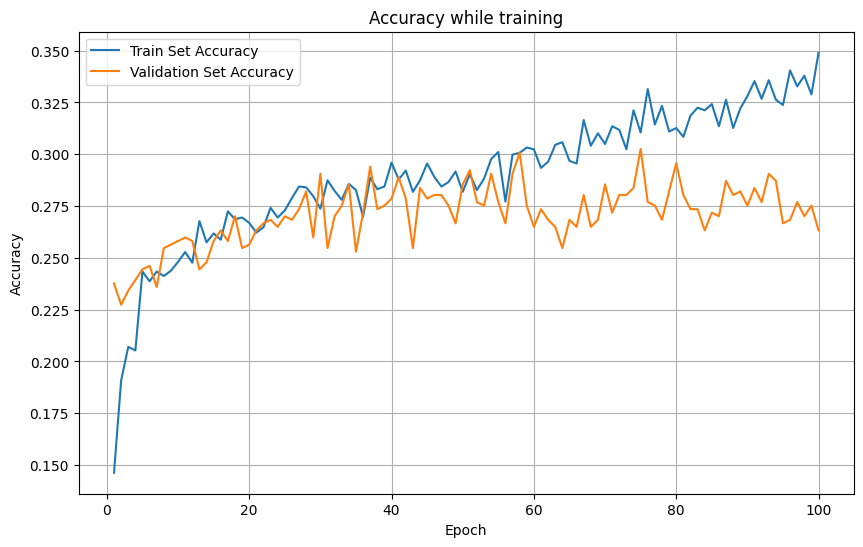

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [57]:
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, predicted))

Test Accuracy: 0.2831
Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           3       0.38      0.47      0.42        19
           4       0.58      0.31      0.41        45
           5       0.35      0.49      0.41        77
           6       0.40      0.43      0.41       129
           7       0.33      0.41      0.37       164
           8       0.31      0.31      0.31       212
           9       0.24      0.35      0.29       191
          10       0.21      0.11      0.14       137
          11       0.18      0.02      0.04        84
          12       0.12      0.28      0.17        53
          13       0.00      0.00      0.00        34
          14       0.13      0.16      0.14        31
          15       0.12      0.05      0.07        21
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        15
          18       0.00      0.00   

/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Feature engineering improves, but not significantly.

## Variant 3: Data engineering

To determine the effects of dataset, let's conduct data engineering. In this section, let's try oversampling and filling out missing values.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [15]:
data = pd.read_csv('data/abalone.csv')
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop(['Rings', 'id'], axis=1).values
y = data['Rings'].values - 1

In [16]:
def custom_resample(X, y, min_samples=6):
    class_counts = Counter(y)
    oversampler = RandomOverSampler(sampling_strategy={k: max(v, min_samples) for k, v in class_counts.items()}, random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    smote_sampler = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote_sampler.fit_resample(X_resampled, y_resampled)
    
    return X_resampled, y_resampled

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_resampled, y_train_resampled = custom_resample(X_train_scaled, y_train)

X_train_tensor = torch.FloatTensor(X_train_resampled).unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train_resampled)
X_val_tensor = torch.FloatTensor(X_val_scaled).unsqueeze(1)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
y_test_tensor = torch.LongTensor(y_test)

In [18]:
class AbaloneDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = AbaloneDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = AbaloneDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = AbaloneDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
class AbaloneClassificationConv1D(nn.Module):
    def __init__(self, num_classes):
        super(AbaloneClassificationConv1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(np.unique(y)) + 1
net = AbaloneClassificationConv1D(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()

    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)
     
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Train Accuracy: 0.5349, Validation Accuracy: 0.2188
Epoch [20/100], Train Accuracy: 0.5808, Validation Accuracy: 0.2444
Epoch [30/100], Train Accuracy: 0.6177, Validation Accuracy: 0.2359
Epoch [40/100], Train Accuracy: 0.6247, Validation Accuracy: 0.2222
Epoch [50/100], Train Accuracy: 0.6448, Validation Accuracy: 0.2410
Epoch [60/100], Train Accuracy: 0.6444, Validation Accuracy: 0.2342
Epoch [70/100], Train Accuracy: 0.6754, Validation Accuracy: 0.2513
Epoch [80/100], Train Accuracy: 0.6311, Validation Accuracy: 0.2359
Epoch [90/100], Train Accuracy: 0.6811, Validation Accuracy: 0.2376
Epoch [100/100], Train Accuracy: 0.6855, Validation Accuracy: 0.2256


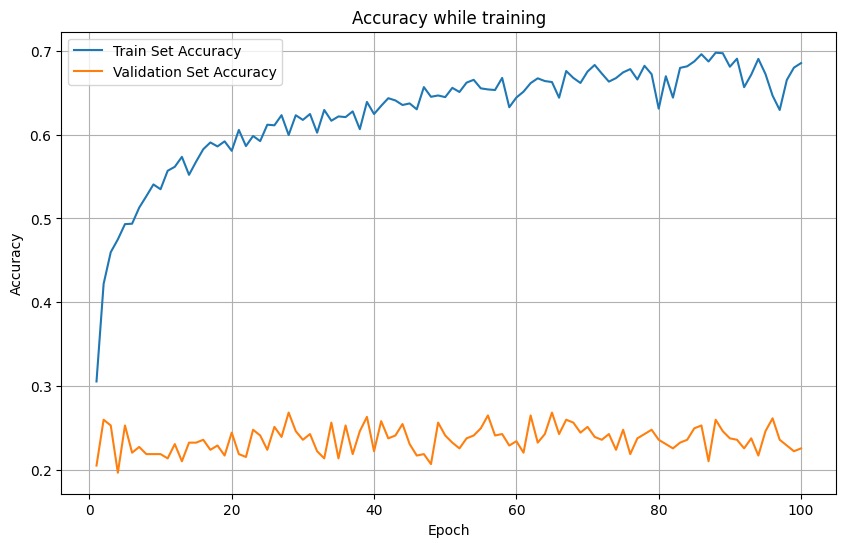

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [22]:
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, predicted))

Test Accuracy: 0.1882
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         3
           3       0.17      0.16      0.16        19
           4       0.32      0.27      0.29        45
           5       0.33      0.09      0.14        77
           6       0.37      0.58      0.45       129
           7       0.35      0.30      0.33       164
           8       0.31      0.12      0.18       212
           9       0.11      0.03      0.04       191
          10       0.20      0.18      0.19       137
          11       0.11      0.23      0.15        84
          12       0.06      0.09      0.08        53
          13       0.04      0.06      0.05        34
          14       0.04      0.10      0.05        31
          15       0.05      0.14      0.08        21
          16       0.00      0.00   

/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

The accuracy in test dataset became worse, which implies using Random Oversampling + SMOTE cannot produce real-world-like data in this experiment.

## Final Results

Changing the order of the columns in the dataset achieved highest score in this series of experiments.